<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Natural Language Processing (NLP)
## *Data Science Unit 4 Sprint 1 Assignment 1*

Your goal in assignment: find the attributes of the best & worst coffee shops in the dataset. The text is fairly raw: dates in the review, extra words in the `star_rating` column, etc. You'll probably want to clean that stuff up for a better analysis. 

Analyze the corpus of text using text visualizations of token frequency. Try cleaning the data as much as possible. Try the following techniques: 
- Lemmatization
- Custom stopword removal

Keep in mind the attributes of good tokens. Once you have a solid baseline, layer in the star rating in your visualization(s). Keep part in this assignment - produce a write-up of the attributes of the best and worst coffee shops. Based on your analysis, what makes the best the best and the worst the worst. Use graphs and numbesr from your analysis to support your conclusions. There should be plenty of markdown cells! :coffee:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re
import spacy
from spacy.tokenizer import Tokenizer
from nltk.stem import PorterStemmer
import squarify

In [2]:
# function given in lecture for creating a dataframe from a df column of counters
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [3]:
# setting up natural language processor and tokenizer
nlp = spacy.load('en_core_web_lg')
tokenizer = Tokenizer(nlp.vocab)

In [4]:
# creates stop words
STOPWORDS = nlp.Defaults.stop_words

In [5]:
# creates a function for removing stop words
def rm_stopwords(tkns):
    '''
    a function for removing stop words from a list of tokens
    '''
    tok_list = []
    for tok in tkns:
        if str(tok) not in STOPWORDS.union(' '):
            tok_list.append(tok)
            
    return(tok_list)

In [6]:
url = "https://raw.githubusercontent.com/LambdaSchool/DS-Unit-4-Sprint-1-NLP/master/module1-text-data/data/yelp_coffeeshop_review_data.csv"

shops = pd.read_csv(url)
shops.head()

,coffee_shop_name,full_review_text,star_rating
0,The Factory - Cafe With a Soul,11/25/2016 1 check-in Love love loved the atm...,5.0 star rating
1,The Factory - Cafe With a Soul,"12/2/2016 Listed in Date Night: Austin, Ambia...",4.0 star rating
2,The Factory - Cafe With a Soul,11/30/2016 1 check-in Listed in Brunch Spots ...,4.0 star rating
3,The Factory - Cafe With a Soul,11/25/2016 Very cool decor! Good drinks Nice ...,2.0 star rating
4,The Factory - Cafe With a Soul,12/3/2016 1 check-in They are located within ...,4.0 star rating


In [7]:
# copies dataframe to new df
df = shops.copy()

# renames columns for ease of use later
df.columns=['shop', 'text', 'rating']

# changes rating column to have only the number (still as a string)
df['rating'] = df['rating'].str[1:4]

# converts number string to float, then float to int
df['rating'] = df['rating'].astype(float)
df['rating'] = df['rating'].astype(int)

# creates a date column
df['date'] = df['text'].str.split(' ').apply(lambda x: x[1])

# converts data column to datetime dtype
df['date'] = df['date'].apply(pd.to_datetime)

# removes punctuation with regex given in lecture
df['text'] = df['text'].apply(lambda x: re.sub(r'[^a-zA-Z ^0-9]', '', x))

# changes text to be lowercase
df['text'] = df['text'].apply(lambda x: x.lower())

# creates a new column with tokenized data using lecture function
df['tokens'] = df['text'].apply(tokenizer)

# takes every token past the date token
df['tokens'] = df['tokens'].apply(lambda x: x[2:])

df['tokens'] = df['tokens'].apply(lambda x: rm_stopwords(x))

# converts tokens to list of lemmas
df['tokens'] = df['tokens'].apply(lambda x: 
                [token.lemma_ for token in x])

# creates a counter for the tokens
df['counter'] = df['tokens'].apply(Counter)

In [8]:
df.head()

,shop,text,rating,date,tokens,counter
0,The Factory - Cafe With a Soul,11252016 1 checkin love love loved the atmosp...,5,2016-11-25,"[1, checkin, love, love, love, atmosphere, cor...","{'1': 1, 'checkin': 1, 'love': 3, 'atmosphere'..."
1,The Factory - Cafe With a Soul,1222016 listed in date night austin ambiance ...,4,2016-12-02,"[list, date, night, austin, ambiance, austin, ...","{'list': 1, 'date': 1, 'night': 1, 'austin': 2..."
2,The Factory - Cafe With a Soul,11302016 1 checkin listed in brunch spots i l...,4,2016-11-30,"[1, checkin, list, brunch, spot, love, eclecti...","{'1': 1, 'checkin': 1, 'list': 1, 'brunch': 2,..."
3,The Factory - Cafe With a Soul,11252016 very cool decor good drinks nice sea...,2,2016-11-25,"[cool, decor, good, drink, nice, seat, overpri...","{'cool': 1, 'decor': 1, 'good': 1, 'drink': 1,..."
4,The Factory - Cafe With a Soul,1232016 1 checkin they are located within the...,4,2016-12-03,"[1, checkin, locate, northcross, mall, shop, c...","{'1': 1, 'checkin': 1, 'locate': 1, 'northcros..."


## How do we want to analyze these coffee shop tokens? 

- Overall Word / Token Count
- View Counts by Rating 
- *Hint:* a 'bad' coffee shops has a rating betweeen 1 & 3 based on the distribution of ratings. A 'good' coffee shop is a 4 or 5. 

In [9]:
# sums the rows into one counter
wordCount = df['counter'].sum()

In [10]:
# creates dataframes for good and bad ratings
dfGood = df[df['rating'] > 3]
dfBad = df[df['rating'] < 4]

# makes sure the size of the new dataframes add up to the size of the original dataframe
assert len(df) == len(dfGood) + len(dfBad)

In [11]:
# creates counters for good/bad reivews
wordCountGood = dfGood['counter'].sum()
wordCountBad = dfBad['counter'].sum()

In [12]:
# looks at top 10 words from all reviews using lecture function
# drops empty word
wordsDF = count(df['counter'])
wordsDF.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
17,coffee,4924,10593,1.0,0.028664,0.028664,0.646534
124,place,3888,6044,2.0,0.016355,0.045019,0.510504
162,good,2883,4154,3.0,0.011241,0.056260,0.378545
80,great,2853,3946,4.0,0.010678,0.066937,0.374606
146,like,2267,3364,5.0,0.009103,0.076040,0.297663
419,come,1935,2636,6.0,0.007133,0.083173,0.254070
456,time,1753,2380,7.0,0.006440,0.089613,0.230173
28,love,1819,2376,8.0,0.006429,0.096043,0.238839
33,drink,1651,2375,9.0,0.006427,0.102469,0.216780
1,shop,1669,2253,10.0,0.006097,0.108566,0.219144


In [13]:
# looks at top 10 words used in good reviews

wordsGoodDF = count(dfGood['counter'])
wordsGoodDF.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
17,coffee,3976,8421,1.0,0.029231,0.029231,0.647557
124,place,3133,4816,2.0,0.016717,0.045949,0.510261
80,great,2505,3474,3.0,0.012059,0.058008,0.407980
170,good,2279,3245,4.0,0.011264,0.069272,0.371173
193,like,1673,2423,5.0,0.008411,0.077682,0.272476
28,love,1608,2121,6.0,0.007362,0.085045,0.261889
379,come,1483,1986,7.0,0.006894,0.091939,0.241531
50,austin,1547,1969,8.0,0.006835,0.098774,0.251954
1,shop,1354,1820,9.0,0.006318,0.105091,0.220521
18,1,1713,1793,10.0,0.006224,0.111315,0.278990


In [14]:
# looks at top 10 words used in good reviews

wordsBadDF = count(dfBad['counter'])
wordsBadDF.head(10)

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
17,coffee,948,2172,1.0,0.026660,0.026660,0.642276
12,place,755,1228,2.0,0.015073,0.041733,0.511518
14,like,594,941,3.0,0.011550,0.053283,0.402439
34,good,604,909,4.0,0.011157,0.064440,0.409214
139,order,443,780,5.0,0.009574,0.074014,0.300136
114,come,452,650,6.0,0.007978,0.081992,0.306233
198,time,422,614,7.0,0.007536,0.089529,0.285908
30,drink,365,613,8.0,0.007524,0.097053,0.247290
57,food,316,494,9.0,0.006064,0.103116,0.214092
62,great,348,472,10.0,0.005793,0.108910,0.235772


## Can visualize the words with the greatest difference in counts between 'good' & 'bad'?

Couple Notes: 
- Rel. freq. instead of absolute counts b/c of different numbers of reviews
- Only look at the top 5-10 words with the greatest differences


In [15]:
# creates dataframe for seeing difference in word use for good/bad review word useage

badDF = wordsBadDF[['word', 'appears_in_pct']]
badDF.columns = ['word', 'percentage_in_bad']

goodDF = wordsGoodDF[['word', 'appears_in_pct']]
goodDF.columns = ['word', 'percentage_in_good']

wordPercents = pd.merge(goodDF, badDF, on='word')

In [16]:
# creates a difference column
wordPercents['difference'] = wordPercents['percentage_in_good'] - wordPercents['percentage_in_bad']

In [17]:
# shows top 10 words used more in good reviews than bad reviews
wordPercents.sort_values('difference', ascending=False).head()

,word,percentage_in_good,percentage_in_bad,difference
2,great,0.407980,0.235772,0.172208
24,delicious,0.191857,0.056233,0.135624
5,love,0.261889,0.142954,0.118935
17,friendly,0.231270,0.122629,0.108642
7,austin,0.251954,0.163279,0.088675


In [18]:
# shows top 10 words used more in bad reviews than good reviews
wordPercents.sort_values('difference').head()

,word,percentage_in_good,percentage_in_bad,difference
22,order,0.167590,0.300136,-0.132546
4,like,0.272476,0.402439,-0.129963
269,okay,0.032899,0.145664,-0.112765
36,do,0.133876,0.238482,-0.104606
152,ask,0.050651,0.149051,-0.098400


## Presentation Data Analysis

In [19]:
# I was not given a coffee shop to analyze so I picked one with a name I liked

# creating df with only 
tbc = df[df['shop'] == 'Thunderbird Coffee ']

tbc.head()

,shop,text,rating,date,tokens,counter
2888,Thunderbird Coffee,10262016 1 checkin after living in sf for man...,4,2016-10-26,"[1, checkin, live, sf, year, ive, develope, pr...","{'1': 1, 'checkin': 1, 'live': 1, 'sf': 1, 'ye..."
2889,Thunderbird Coffee,9172016 1 checkin i came a few minutes before...,4,2016-09-17,"[1, checkin, come, minute, close, host, happil...","{'1': 1, 'checkin': 1, 'come': 3, 'minute': 1,..."
2890,Thunderbird Coffee,962016 1 checkin easy to spot and is located ...,4,2016-09-06,"[1, checkin, easy, spot, locate, nice, little,...","{'1': 1, 'checkin': 1, 'easy': 1, 'spot': 5, '..."
2891,Thunderbird Coffee,1232016 plenty of seating limited selection o...,4,2016-12-03,"[plenty, seat, limit, selection, bake, good, a...","{'plenty': 1, 'seat': 2, 'limit': 1, 'selectio..."
2892,Thunderbird Coffee,6242016 updated review 1 checkin i love thund...,5,2016-06-24,"[update, review, 1, checkin, love, thunderbird...","{'update': 1, 'review': 1, '1': 1, 'checkin': ..."


In [20]:
# looking at basic data from the review tab

tbc['rating'].describe()

count    100.000000
mean       3.970000
std        0.999545
min        1.000000
25%        4.000000
50%        4.000000
75%        5.000000
max        5.000000
Name: rating, dtype: float64

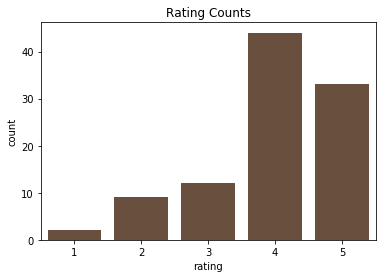

In [21]:
ratingCount = pd.DataFrame(tbc['rating'].value_counts()).reset_index()

ratingCount.columns = ['rating', 'count']

ratingCount.sort_values('rating')

sns.barplot(x=ratingCount['rating'], 
            y=ratingCount['count'], 
            color='#6f4e37').set_title('Rating Counts')

plt.savefig('rating_counts.png')
plt.show();

In [22]:
# splits dataframe into three time periods to compare ratings over time

late = tbc[tbc['date'] >= '2016-2']

mid = tbc[(tbc['date'] < '2016-2') &
                (tbc['date'] >= '2015-5')]
                
early = tbc[tbc['date'] < '2015-5']

assert(len(late) + len(mid) + len(early) == len(tbc))

In [23]:
# gets average rating for time periods
earlyAVG = early['rating'].sum()/len(late)
midAVG = mid['rating'].sum()/len(late)
lateAVG = late['rating'].sum()/len(late)

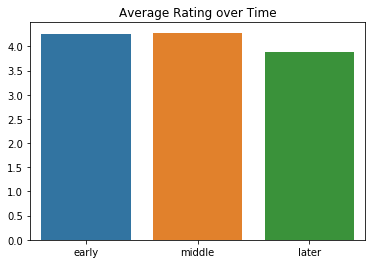

In [34]:
# plots the averages

avgs = [earlyAVG, midAVG, lateAVG]
labels = ['early', 
          'middle', 
          'later']

sns.barplot(x=labels, y=avgs).set_title('Average Rating over Time');
plt.savefig('avg_rating.png')
plt.show();

In [44]:
lateAVG

3.875

In [26]:
# creates dataframes for good and bad ratings
tbcGood = dfGood[dfGood['shop'] == 'Thunderbird Coffee ']
tbcBad = dfBad[dfBad['shop'] == 'Thunderbird Coffee ']

# makes sure the size of the new dataframes add up to the size of the original dataframe
assert len(tbc) == len(tbcGood) + len(tbcBad)

In [27]:
# looks at top 5 words from good reviews using lecture function

good_words = count(tbcGood['counter'])

good_words.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
23,coffee,61,121,1.0,0.030986,0.030986,0.792208
91,good,42,68,2.0,0.017414,0.048399,0.545455
64,place,40,65,3.0,0.016645,0.065045,0.519481
27,latte,28,48,4.0,0.012292,0.077337,0.363636
156,great,31,43,5.0,0.011012,0.088348,0.402597


In [28]:
# looks at top 5 words from bad reviews using lecture function

bad_words = count(tbcBad['counter'])

bad_words.head()

,word,appears_in,count,rank,pct_total,cul_pct_total,appears_in_pct
18,coffee,20,41,1.0,0.029883,0.029883,0.869565
38,place,9,24,2.0,0.017493,0.047376,0.391304
129,order,10,19,3.0,0.013848,0.061224,0.434783
41,like,8,14,4.0,0.010204,0.071429,0.347826
69,im,8,13,5.0,0.009475,0.080904,0.347826


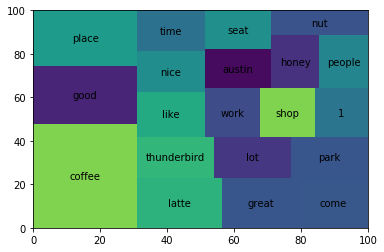

In [29]:
top20good = good_words[good_words['rank'] < 21]

squarify.plot(sizes=top20good['count'], label=top20good['word'])

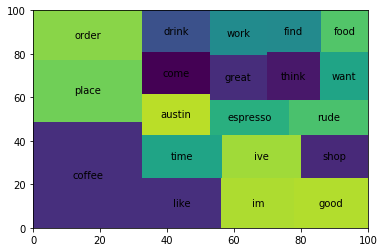

In [30]:
top20bad = bad_words[bad_words['rank'] < 21]

squarify.plot(sizes=top20bad['count'], label=top20bad['word'])

In [31]:
# creates dataframe for seeing difference in word use for good/bad review word useage
badDFtbc = bad_words[['word', 'appears_in_pct']]
badDFtbc.columns = ['word', 'percentage_in_bad']

goodDFtbc = good_words[['word', 'appears_in_pct']]
goodDFtbc.columns = ['word', 'percentage_in_good']

wordPercents_tbc = pd.merge(goodDFtbc, badDFtbc, on='word')

# creates a difference column
wordPercents_tbc['difference'] = wordPercents_tbc['percentage_in_good'] - wordPercents_tbc['percentage_in_bad']

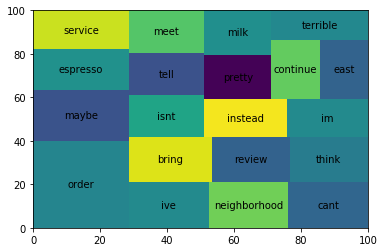

In [32]:
# shows top 20 words used more in bad reviews than good reviews
badPercents = wordPercents_tbc.sort_values('difference').head(20)

squarify.plot(sizes=badPercents['difference'].apply(abs), 
              label=badPercents['word'])

plt.savefig('bad.png')
plt.show()

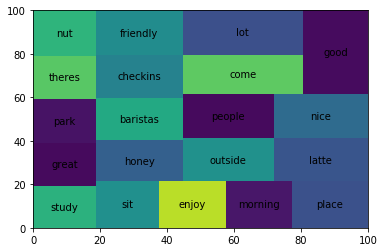

In [33]:
# shows top 10 words used more in bad reviews than good reviews
goodPercents = wordPercents_tbc.sort_values('difference').tail(20)

squarify.plot(sizes=goodPercents['difference'].apply(abs), 
              label=goodPercents['word'])

plt.savefig('good.png')
plt.show()

## Stretch Goals

* Analyze another corpus of documents - such as Indeed.com job listings ;).
* Play the the Spacy API to
 - Extract Named Entities
 - Extracting 'noun chunks'
 - Attempt Document Classification with just Spacy
 - *Note:* This [course](https://course.spacy.io/) will be of interesting in helping you with these stretch goals. 
* Try to build a plotly dash app with your text data 

